In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

#Import block from src
from src.util.helper import read_data,convert_to_pkl
from src.util.preparator import union,prepare_training
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D,Conv2D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
import numpy as np
from joblib import dump, load
from settings import setting
from sklearn.metrics import average_precision_score,classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score,auc,roc_curve
import matplotlib.pyplot as plt
from src.util.helper import read_data,convert_to_pkl
import time 

read in setting {'paths': {'wd': '/Users/fabiogruschka/Documents/uni/ws2021/bachelor/bachelor_v2', 'data': '/Users/fabiogruschka/Documents/uni/ws2021/bachelor/bachelor_v2/data/intern', 'logs': '/Users/fabiogruschka/Documents/uni/ws2021/bachelor/bachelor_v2/logs', 'reports': '/Users/fabiogruschka/Documents/uni/ws2021/bachelor/bachelor_v2/reports', 'models': '/Users/fabiogruschka/Documents/uni/ws2021/bachelor/bachelor_v2/models', 'scores': '/Users/fabiogruschka/Documents/uni/ws2021/bachelor/bachelor_v2/data/scores', 'html': '/Users/fabiogruschka/Documents/uni/ws2021/bachelor/bachelor_v2/src/assets/html'}, 'resolutions': array([ 50, 100, 150]), 'mode': {'prep': True, 'viz': False, 'pred': True, 'train': True}, 'models': ['rf', 'lr', 'svm', 'cnn'], 'colors': ['Greens', 'Reds', 'Blues', 'Yellows']}


Using TensorFlow backend.


In [13]:
import tensorflow as tf
config_2 = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=0,
                        inter_op_parallelism_threads=2,
                        allow_soft_placement=True)

session = tf.compat.v1.Session(config=config_2)

In [155]:
convert_to_pkl(setting)

In [2]:
prep_data = prepare_training(union(read_data()))

[+].src.util.preparator: union dataframes done
[+].src.util.preparator: prepare training done


In [14]:
config = {
    'layers': sorted([x for x in range(3,10)],reverse=True)
}

In [15]:
def train_cnn(dictionary,  i):
    X_train = dictionary['X_train']

    X_test = dictionary['X_test']
    from keras.utils import to_categorical
    # one-hot encode target column
    y_train = to_categorical(dictionary['y_train'])
    y_test = to_categorical(dictionary['y_test'])

    verbose, epochs, batch_size = 0, 50, 32
    model = Sequential()
    # add model layers
    model.add(Dense(i,  activation='tanh', input_dim=dictionary['X_train'].shape[1]))
    model.add(Dense(i-1,  activation='tanh'))
    model.add(Dense(i-2,  activation='tanh'))
    model.add(Dense(2, activation='tanh'))
    # compile model using accuracy to measure model performance
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    # fit network
    history = model.fit(X_train,
              y_train,
              validation_data=(X_test, y_test),
              epochs=epochs,
              #batch_size=batch_size,
              verbose=verbose)
    
    print(f"Size of First layer {i}")
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss']) 
    plt.plot(history.history['val_loss']) 
    plt.title('Model loss') 
    plt.ylabel('Loss') 
    plt.xlabel('Epoch') 
    plt.legend(['Train', 'Test'], loc='upper left') 
    plt.show()

    return model,history

Size of First layer 9


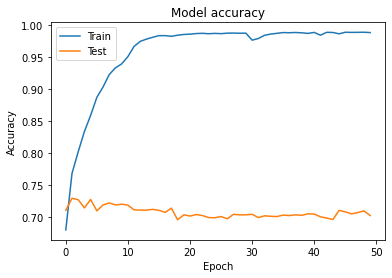

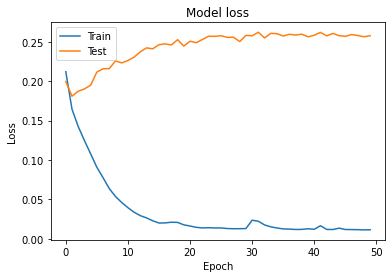

Size of First layer 8


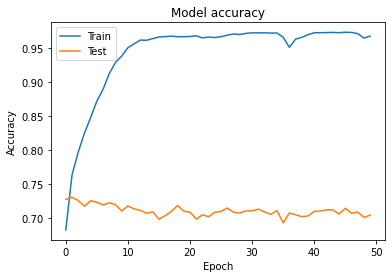

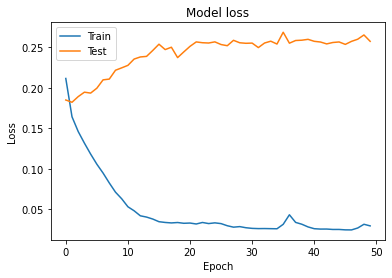

Size of First layer 7


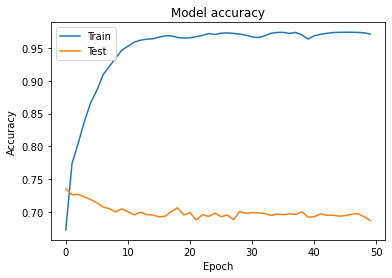

Size of First layer 6


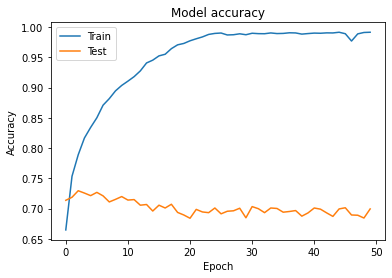

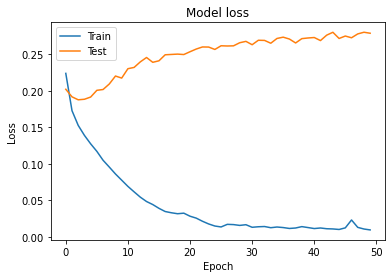

Size of First layer 5


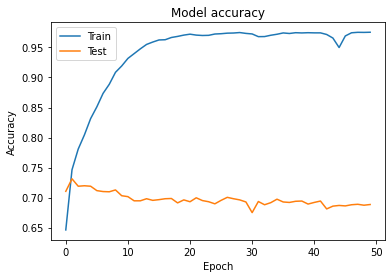

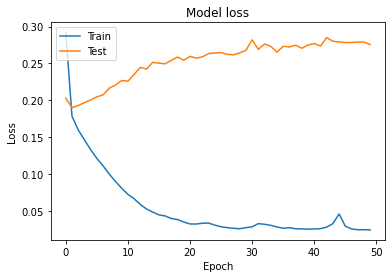

Size of First layer 4


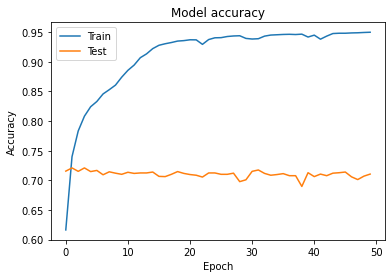

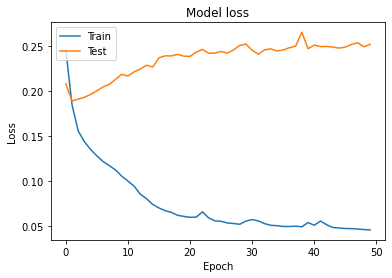

Size of First layer 3


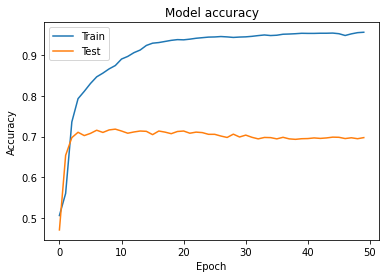

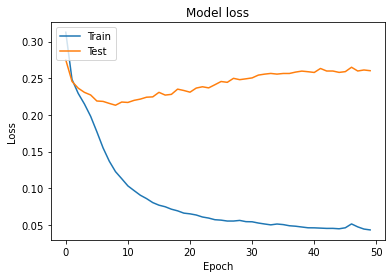

Request took 365.8450150489807


In [16]:
start = time.time()
for i in config['layers']:
    cnn_model,history = train_cnn(prep_data['protein_50_0'],   i)
print("Request took {}".format(time.time()-start))

In [64]:
dump(cnn_model, os.path.join(setting['paths']['models'], 'cnn_mod_{}.joblib'.format('protein_50_1')))

['/Users/fabiogruschka/Documents/uni/ws2021/bachelor/bachelor_v2/models/cnn_mod_protein_50_1.joblib']

In [65]:
import pandas as pd
result_table = pd.DataFrame(columns=['classifiers', 'dataset', 'fpr','tpr','se','sp','acc','mcc','auc'])

In [66]:
def predictor(dictionary, model, key):
    if 'Sequential' in model.__class__.__name__:
        X_test = dictionary['X_test']

        y_pred = model.predict_classes(X_test)
    else:
        # Actual class predictions
        y_pred = model.predict(dictionary['X_test'])
        print('Accuracy of classifier on test set: {:.2f}'.format(
            model.score(dictionary['X_test'], dictionary['y_test'])))

    tn, fp, fn, tp = confusion_matrix(dictionary['y_test'], y_pred).ravel()

    specificity = tn / (tn + fp)
    sensifity = tp / (tp + fn)
    acc = (tp + tn) / (tp + tn +fn+fp)
    mcc = (tp * tn - fp * fn) / np.sqrt((tp+fp) * (tp+fn) * (tp + fp) * (tp + fn))

    fpr, tpr, _ = roc_curve(dictionary['y_test'], y_pred)
    auc = roc_auc_score(dictionary['y_test'], y_pred)
    # Define a result table as a DataFrame
    global result_table
    result_table = result_table.append({'classifiers': str(model.__class__.__name__),
                                        'dataset': key,
                                        'fpr': fpr,
                                        'tpr': tpr,
                                        'se': specificity,
                                        'sp' : sensifity,
                                        'acc': acc,
                                        'mcc': mcc,
                                        'auc': auc}, ignore_index=True)

    return result_table




In [67]:
if 'Sequential'in cnn_model.__class__.__name__:
    X_test = prep_data['protein_50_1']['X_test']

    y_pred = cnn_model.predict_classes(X_test)
    print(y_pred)
else:
    # Actual class predictions
    y_pred = model.predict(dictionary['X_test'])
    print('Accuracy of classifier on test set: {:.2f}'.format(model.score(dictionary['X_test'], dictionary['y_test'])))

[0 1 0 ... 1 0 0]


In [68]:
fpr, tpr, _ = roc_curve(prep_data['protein_50_1']['y_test'],  y_pred)

In [69]:

loaded_model = load(os.path.join(setting['paths']['models'],'cnn_mod_protein_50_1.joblib'))
result_table = predictor(prep_data['protein_50_1'],loaded_model,'protein_50_1')



In [70]:
result_table

classifiers       dataset                              fpr  \
0  Sequential  protein_50_1  [0.0, 0.22844509948415623, 1.0]   

                              tpr        se        sp       acc       mcc  \
0  [0.0, 0.7607113985448666, 1.0]  0.771555  0.760711  0.766384  0.577366   

        auc  
0  0.766133

In [143]:
class NumpyArrayEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [144]:
with open(os.path.join(setting['paths']['scores'], 'scores_{}.json'.format(date.today().strftime("%b-%d-%Y"))),'w') as json_file:
    json.dump(result_table.to_dict(),json_file,indent = 4,cls=NumpyArrayEncoder)

In [135]:

data[7]

'c'